In [8]:
# 8a.1 Create choropleth map with Plotly
fig = px.scatter_geo(housing_df,
                    lat='latitude',
                    lon='longitude',
                    color='price',
                    size='area',
                    hover_name='city',
                    hover_data={'price': ':.0f', 'bedrooms': True, 'furnishingstatus': True},
                    projection='natural earth',
                    title='Housing Prices Across US Cities',
                    color_continuous_scale='Blues')

fig.update_geos(scope='north america', showcountries=True, showcoastlines=True, showland=True)
fig.show()

# 8a.2 Dual-axis equivalent with Plotly
# Create a figure with two map layers
fig = go.Figure()

# Layer 1: Price bubbles
fig.add_trace(go.Scattergeo(
    lon = housing_df['longitude'],
    lat = housing_df['latitude'],
    text = housing_df['city'] + ': $' + (housing_df['price']/1000000).round(2).astype(str) + 'M',
    marker = dict(
        size = housing_df['price'] / 500000,
        color = housing_df['price'],
        colorscale = 'Blues',
        line_color='rgb(40,40,40)',
        line_width=0.5,
        sizemode = 'area'
    ),
    name = 'Price (Size & Color)'
))

# Layer 2: Furnishing status (different symbol)
furnished_df = housing_df[housing_df['furnishingstatus'] == 'furnished']
fig.add_trace(go.Scattergeo(
    lon = furnished_df['longitude'],
    lat = furnished_df['latitude'],
    text = 'Furnished: ' + furnished_df['city'],
    marker = dict(
        size = 8,
        symbol = 'star',
        color = 'green'
    ),
    name = 'Furnished Properties'
))

fig.update_layout(
    title_text = 'Dual-Layer Housing Map: Price & Furnishing Status',
    showlegend = True,
    geo = dict(
        scope = 'north america',
        landcolor = 'rgb(217, 217, 217)',
    )
)

fig.show()

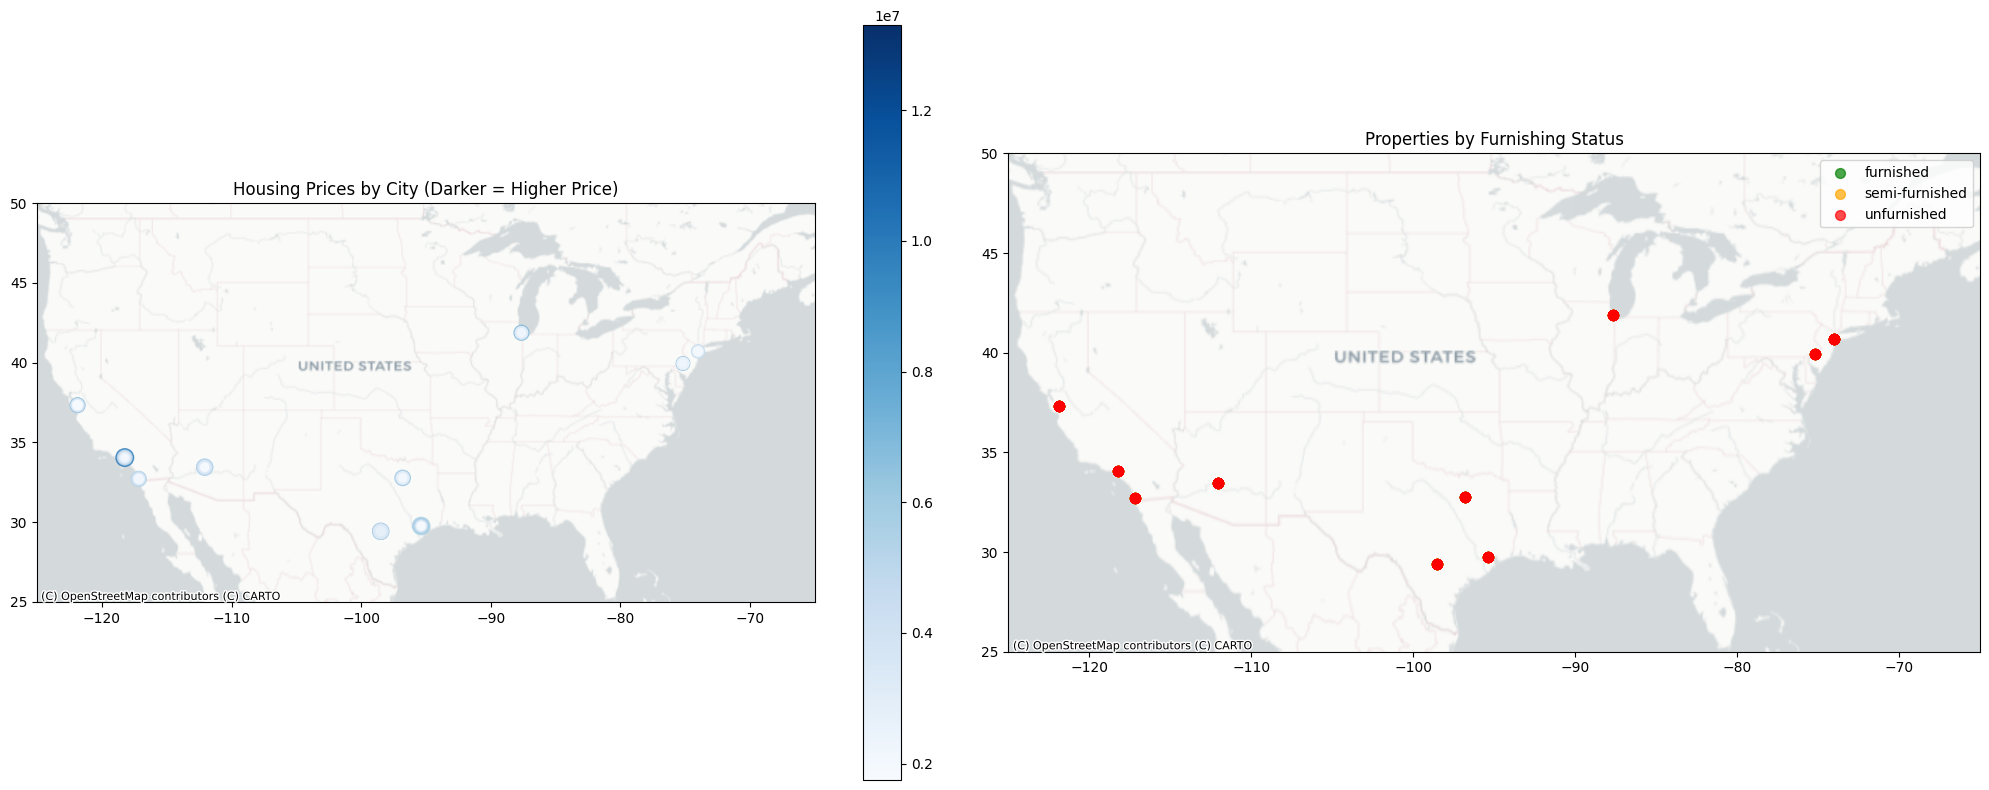

Regional Analysis:
            price                      area bedrooms
             mean     median count     mean     mean
state                                               
AZ     4930536.23  4403000.0    69  5065.61     2.99
CA     4769883.23  4200000.0   164  5198.20     3.01
IL     4917666.67  4585000.0    42  5193.64     3.14
NY     4072393.44  3990000.0    61  4549.31     2.70
PA     4863366.67  4340000.0    45  5044.91     2.96
TX     4887744.45  4497500.0   164  5380.19     2.96


In [9]:
# Create a GeoDataFrame for spatial analysis
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(housing_df['longitude'], housing_df['latitude'])]
gdf = gpd.GeoDataFrame(housing_df, geometry=geometry, crs="EPSG:4326")

# Plot with different regions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Map 1: Price by city
gdf.plot(column='price', ax=ax1, cmap='Blues',
         legend=True, markersize=gdf['area']/100,
         alpha=0.7)
ax1.set_title('Housing Prices by City (Darker = Higher Price)')

# Map 2: Furnishing status
for furnishing, color in [('furnished', 'green'), ('semi-furnished', 'orange'), ('unfurnished', 'red')]:
    subset = gdf[gdf['furnishingstatus'] == furnishing]
    subset.plot(ax=ax2, color=color, label=furnishing, markersize=50, alpha=0.7)

ax2.set_title('Properties by Furnishing Status')
ax2.legend()

# Add basemap (requires internet connection)
try:
    for ax in [ax1, ax2]:
        ax.set_xlim(-125, -65)
        ax.set_ylim(25, 50)
        ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)
except:
    print("Basemap not available, using simple map")

plt.tight_layout()
plt.show()

# Regional analysis
regional_analysis = housing_df.groupby('state').agg({
    'price': ['mean', 'median', 'count'],
    'area': 'mean',
    'bedrooms': 'mean'
}).round(2)

print("Regional Analysis:")
print(regional_analysis)

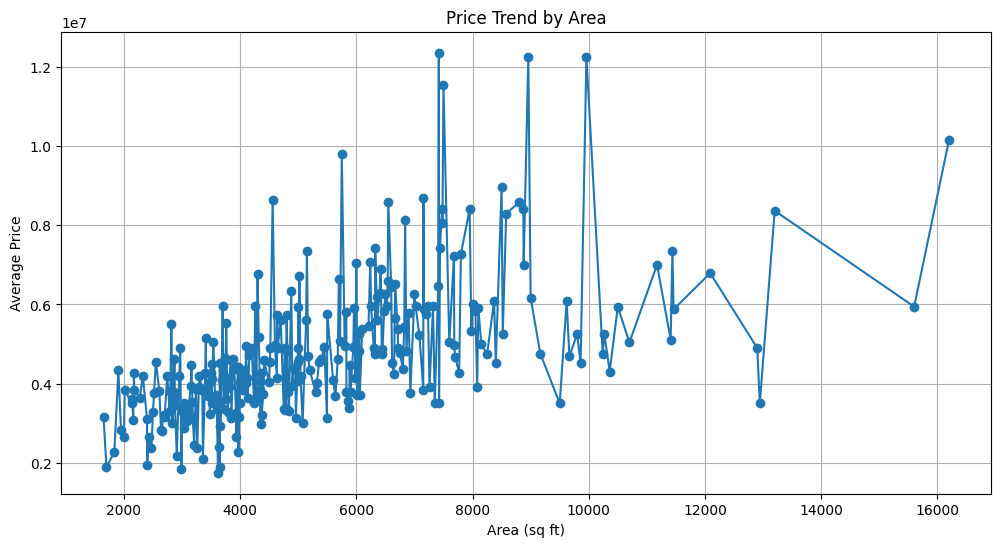

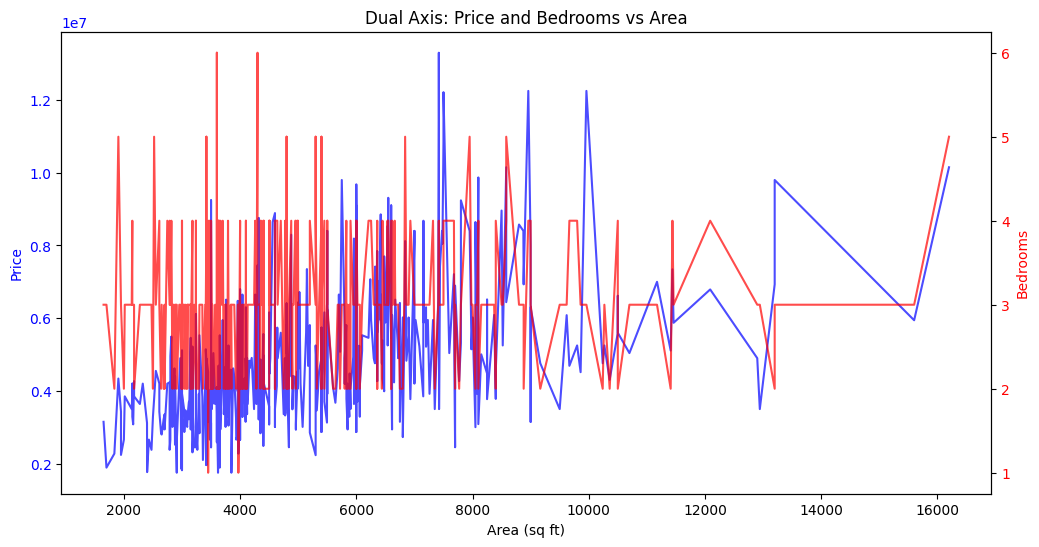

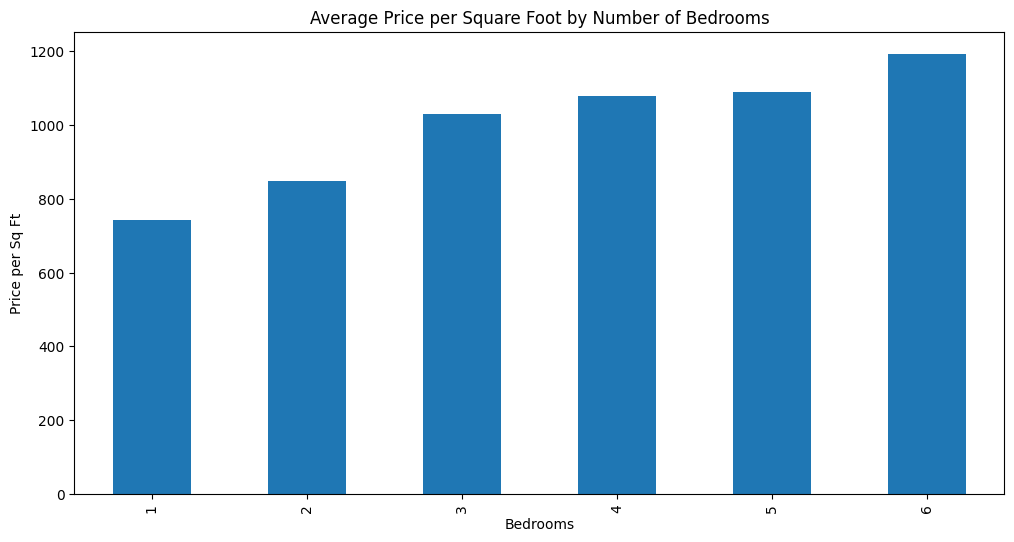

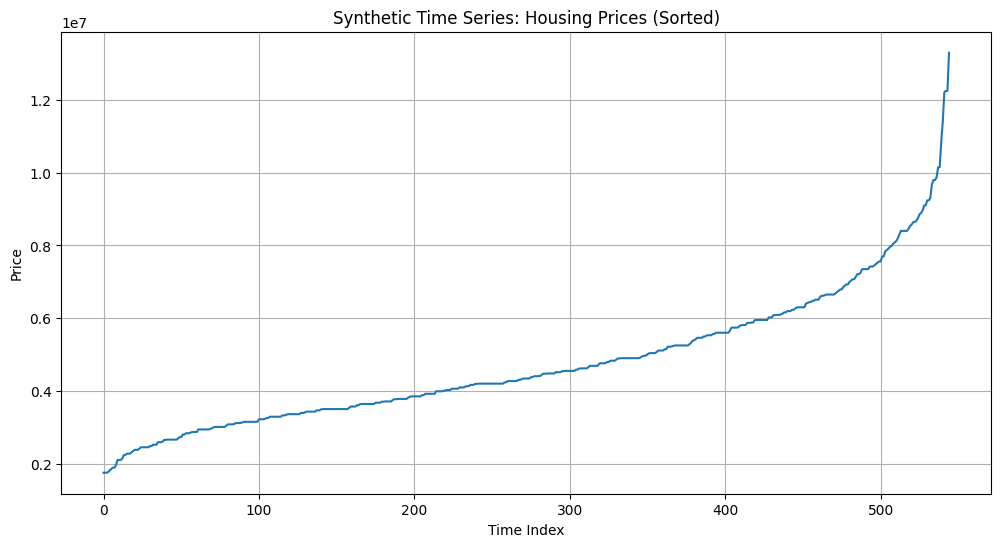

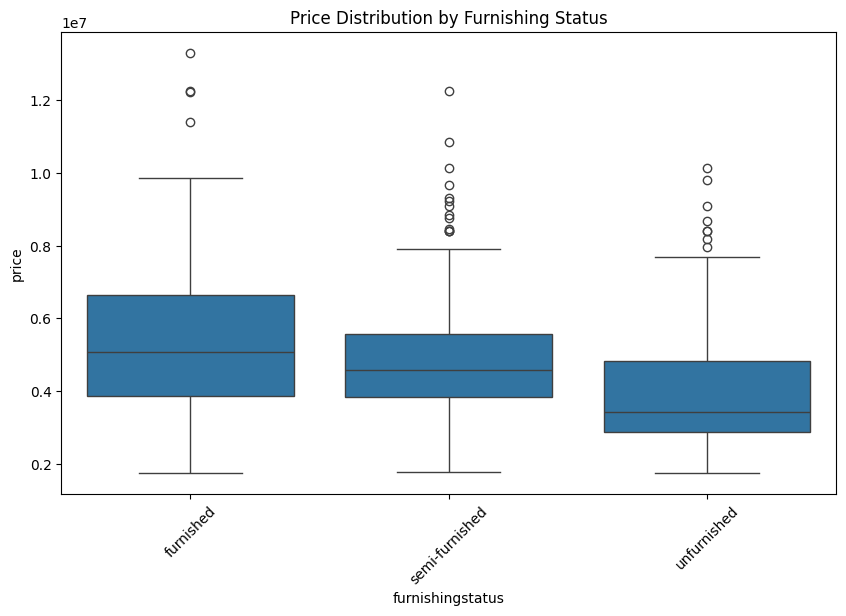

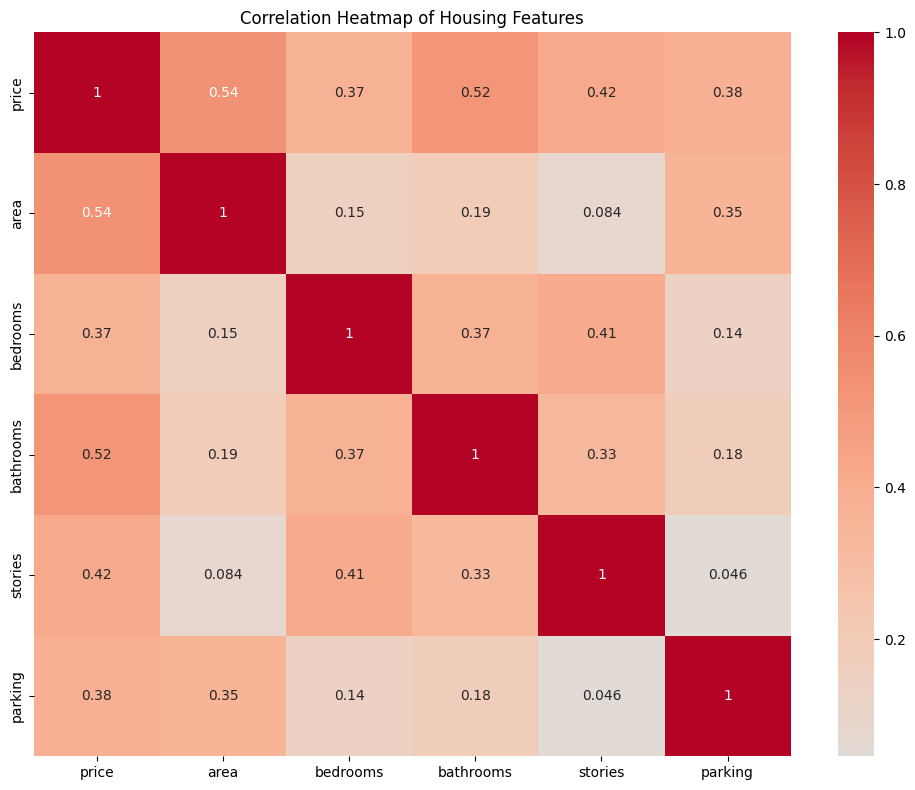

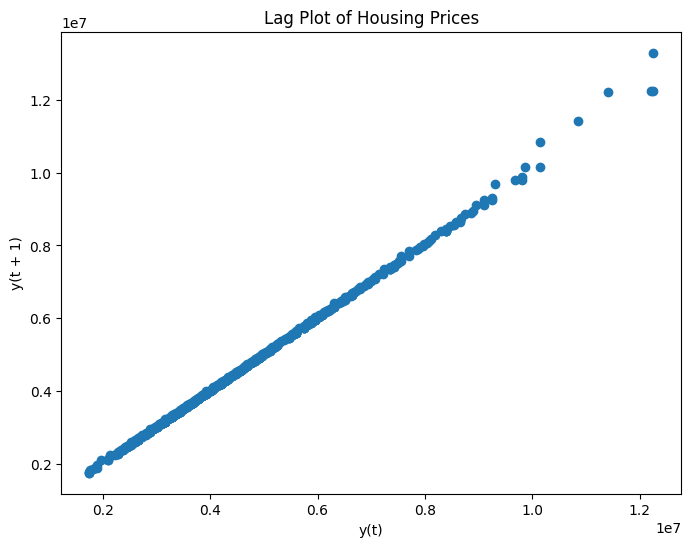

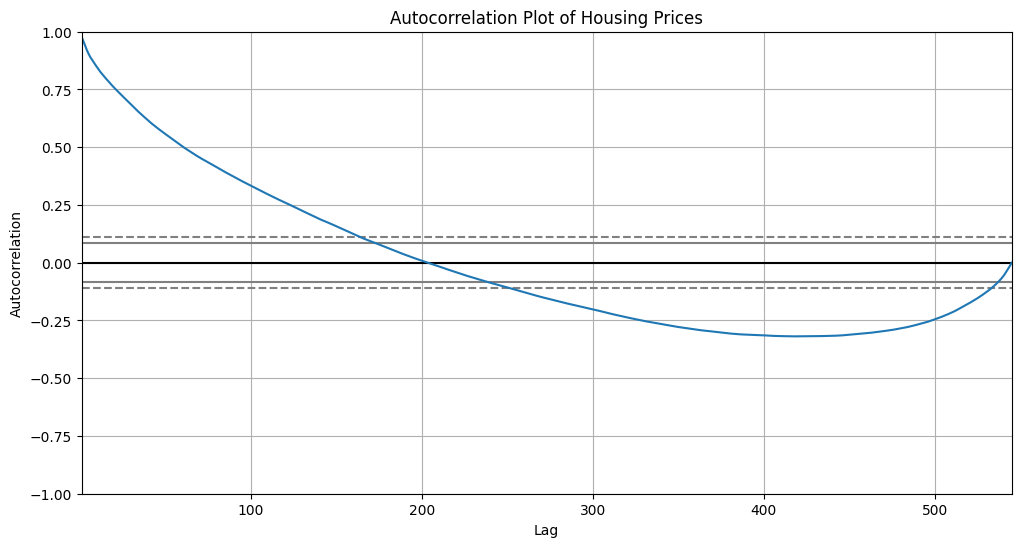

Price analysis by furnishing status:
                          mean           std  count
furnishingstatus                                   
furnished         5.495696e+06  2.117857e+06    140
semi-furnished    4.907524e+06  1.596688e+06    227
unfurnished       4.013831e+06  1.720247e+06    178


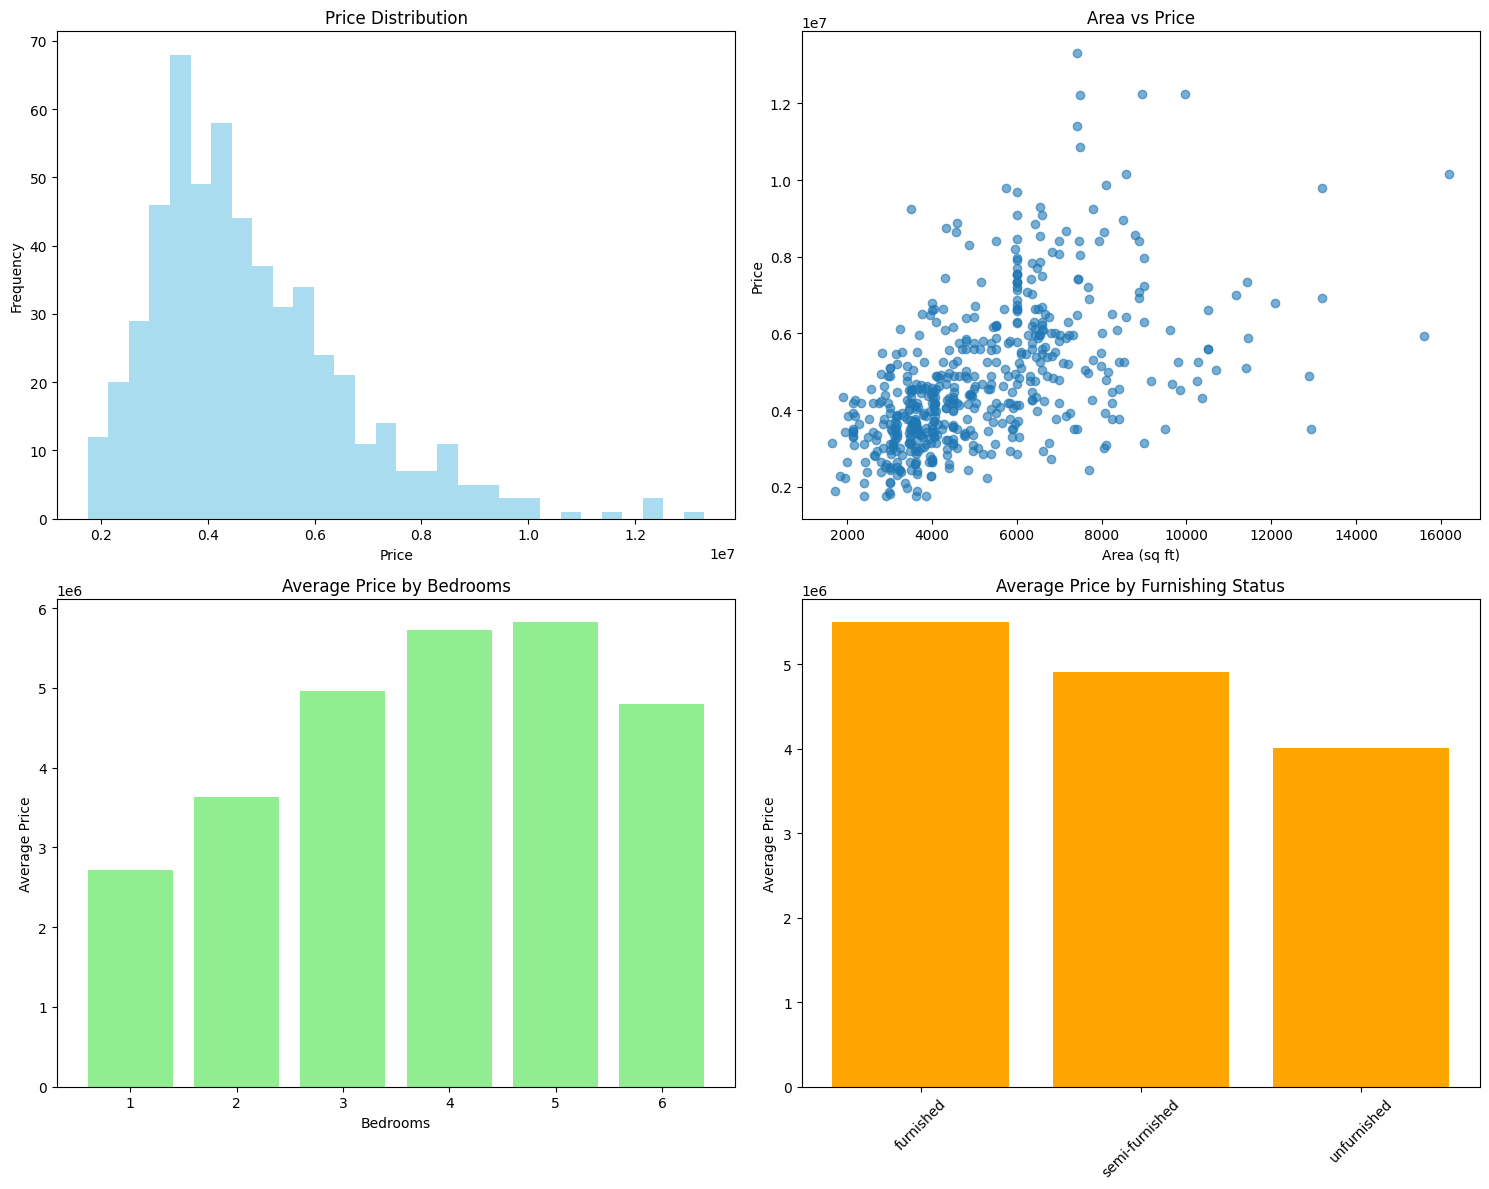

In [3]:
import numpy as np
from pandas.plotting import autocorrelation_plot, lag_plot
import seaborn as sns

plt.figure(figsize=(12, 6))
# Fix: Use the grouped data for both x and y values
area_price_mean = housing_df.groupby('area')['price'].mean()
plt.plot(area_price_mean.index, area_price_mean.values, marker='o')
plt.title('Price Trend by Area')
plt.xlabel('Area (sq ft)')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))
sorted_df = housing_df.sort_values('area')

ax1.plot(sorted_df['area'], sorted_df['price'], 'b-', alpha=0.7, label='Price')
ax1.set_xlabel('Area (sq ft)')
ax1.set_ylabel('Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(sorted_df['area'], sorted_df['bedrooms'], 'r-', alpha=0.7, label='Bedrooms')
ax2.set_ylabel('Bedrooms', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Dual Axis: Price and Bedrooms vs Area')
plt.show()

housing_df['price_per_sqft'] = housing_df['price'] / housing_df['area']

plt.figure(figsize=(12, 6))
housing_df.groupby('bedrooms')['price_per_sqft'].mean().plot(kind='bar')
plt.title('Average Price per Square Foot by Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price per Sq Ft')
plt.show()

time_series_data = housing_df['price'].sort_values().reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data.values)
plt.title('Synthetic Time Series: Housing Prices (Sorted)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=housing_df, x='furnishingstatus', y='price')
plt.title('Price Distribution by Furnishing Status')
plt.xticks(rotation=45)
plt.show()

numerical_features = housing_df[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']]
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Housing Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
lag_plot(time_series_data)
plt.title('Lag Plot of Housing Prices')
plt.show()

plt.figure(figsize=(12, 6))
autocorrelation_plot(time_series_data)
plt.title('Autocorrelation Plot of Housing Prices')
plt.show()

furnishing_trends = housing_df.groupby('furnishingstatus')['price'].agg(['mean', 'std', 'count'])
print("Price analysis by furnishing status:")
print(furnishing_trends)

fig = px.line(housing_df.sort_values('area'), x='area', y='price',
              color='furnishingstatus',
              title='Housing Prices vs Area by Furnishing Status',
              labels={'area': 'Area (sq ft)', 'price': 'Price'})
fig.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].hist(housing_df['price'], bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Price Distribution')
axes[0,0].set_xlabel('Price')
axes[0,0].set_ylabel('Frequency')

axes[0,1].scatter(housing_df['area'], housing_df['price'], alpha=0.6)
axes[0,1].set_title('Area vs Price')
axes[0,1].set_xlabel('Area (sq ft)')
axes[0,1].set_ylabel('Price')

bedroom_prices = housing_df.groupby('bedrooms')['price'].mean()
axes[1,0].bar(bedroom_prices.index, bedroom_prices.values, color='lightgreen')
axes[1,0].set_title('Average Price by Bedrooms')
axes[1,0].set_xlabel('Bedrooms')
axes[1,0].set_ylabel('Average Price')

furnishing_prices = housing_df.groupby('furnishingstatus')['price'].mean()
axes[1,1].bar(range(len(furnishing_prices)), furnishing_prices.values,
              tick_label=furnishing_prices.index, color='orange')
axes[1,1].set_title('Average Price by Furnishing Status')
axes[1,1].set_ylabel('Average Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()